# Laboratorio 3 - Visión por Computadora
## Integrantes:

- Javier Alvarado - 21188
- Mario Guerra - 21008
- Emilio Solano - 21212

![alt text](assets/Lab3_1.png)

In [32]:
import cv2

img_bgr = cv2.imread("assets/person.png")
# Convierte a escala de grises:
gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)


In [33]:
import cv2
import numpy as np

def preprocesar_imagen_opencv(ruta_imagen, k=1, out_dtype='uint8'):
    # Lee imagen en BGR
    img_bgr = cv2.imread(ruta_imagen)
    # Convierte a escala de grises
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    
    # Dimensiones de salida
    ancho = 64 * k
    alto  = 128 * k
    
    # Reescalado (OpenCV recibe (ancho, alto))
    resized = cv2.resize(gray, (ancho, alto), interpolation=cv2.INTER_AREA)
    
    # Opcional: convertir a float en [0,1] o dejar en 8 bits
    if out_dtype == 'float32':
        resized = resized.astype(np.float32) / 255.0
    else:
        resized = resized.astype(np.uint8)

    return resized


In [34]:
import numpy as np
import cv2

def calcular_gradientes(imagen_gray):
    """
    imagen_gray: array 2D numpy con la imagen en escala de grises.
    return: magnitud, orientacion (en radianes o grados).
    """
    # Operador Sobel en X e Y (OpenCV usa cv2.CV_64F por defecto para la salida)
    grad_x = cv2.Sobel(imagen_gray, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(imagen_gray, cv2.CV_64F, 0, 1, ksize=3)

    # Magnitud y orientación
    magnitud = np.sqrt(grad_x**2 + grad_y**2)
    # Orientación en radianes, rango (-pi, pi). Podemos ajustarlo a (0, 2*pi).
    orientacion = np.arctan2(grad_y, grad_x)
    
    return magnitud, orientacion


In [35]:
def construir_histogramas_celdas(magnitud, orientacion, celdas=8, bins=9):
    """
    magnitud, orientacion: arrays 2D de la misma forma
    celdas: tamaño en pixeles de la celda (ej. 8)
    bins: número de bins para la orientación (ej. 9)
    return: hist_celdas, un array 3D de forma (num_celdas_vertical, num_celdas_horizontal, bins)
    """
    alto, ancho = magnitud.shape
    # Cantidad de celdas en la dirección vertical y horizontal
    num_celdas_y = alto  // celdas
    num_celdas_x = ancho // celdas

    # Rango de orientaciones: [0, 180) grados (si se hace “unsigned” HOG)
    # o [0, 360) si se maneja “signed” HOG. Aquí usamos 180 como ejemplo.
    # Convertimos orientaciones de radianes a grados:
    orientacion_grados = np.degrees(orientacion) 
    orientacion_grados[orientacion_grados < 0] += 180  # Para que queden en [0,180)

    bin_width = 180 / bins  # tamaño de cada bin

    # Inicializamos histograma por celda
    hist_celdas = np.zeros((num_celdas_y, num_celdas_x, bins), dtype=np.float32)

    for i in range(num_celdas_y):
        for j in range(num_celdas_x):
            # extraer la región que corresponde a la celda (i,j)
            y_inicio = i * celdas
            y_fin    = y_inicio + celdas
            x_inicio = j * celdas
            x_fin    = x_inicio + celdas

            # Extraer magnitud y orientación en esa celda
            mag_patch = magnitud[y_inicio:y_fin, x_inicio:x_fin]
            ang_patch = orientacion_grados[y_inicio:y_fin, x_inicio:x_fin]

            # Acumular en bins
            for y_local in range(celdas):
                for x_local in range(celdas):
                    ang = ang_patch[y_local, x_local]
                    mag = mag_patch[y_local, x_local]

                    # Determinar el bin principal
                    bin_index = int(ang // bin_width)
                    if bin_index == bins:  # corrección si ang == 180
                        bin_index = bins - 1

                    hist_celdas[i, j, bin_index] += mag
    return hist_celdas


In [36]:
def normalizar_bloques(hist_celdas, celdas_por_bloque=2, eps=1e-5):
    """
    hist_celdas: array (num_celdas_y, num_celdas_x, bins)
    celdas_por_bloque: normalmente 2 (bloque de 2×2 celdas)
    return: descriptor HOG concatenado en 1D o en 3D, según se necesite
    """
    num_celdas_y, num_celdas_x, bins = hist_celdas.shape
    bloque_stride = 1  # se recorre celda por celda

    # Número de bloques en horizontal y vertical
    num_bloques_y = (num_celdas_y - celdas_por_bloque) // bloque_stride + 1
    num_bloques_x = (num_celdas_x - celdas_por_bloque) // bloque_stride + 1

    # Podríamos almacenar cada bloque normalizado y luego concatenar
    hog_descriptor = []

    for y in range(num_bloques_y):
        for x in range(num_bloques_x):
            # Extraer el histograma de celdas en este bloque (2×2)
            block_hist = hist_celdas[y : y + celdas_por_bloque,
                                     x : x + celdas_por_bloque, :]
            # Flatten del bloque (2×2×bins -> vector 1D)
            block_vector = block_hist.flatten()

            # Normalización L2
            norma = np.sqrt(np.sum(block_vector**2) + eps**2)
            block_vector_norm = block_vector / norma

            hog_descriptor.append(block_vector_norm)

    # Concatenar todos los bloques en un solo vector final
    hog_descriptor = np.concatenate(hog_descriptor)
    return hog_descriptor


In [37]:
from skimage.feature import hog
import matplotlib.pyplot as plt

def hog_descriptor(ruta_imagen, k=1, celdas=8, bins=9, celdas_por_bloque=2):
    """
    Calcula el descriptor HOG a partir de una imagen en 'ruta_imagen'
    con tamaño de salida 128k×64k.
    """
    # 1. Preprocesado
    img = preprocesar_imagen_opencv(ruta_imagen, k=k, out_dtype='uint8')

    fd, hog_image = hog(img,
                    orientations=9,
                    pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2),
                    visualize=True,
                    block_norm='L2-Hys')

    plt.imshow(hog_image, cmap='gray')
    plt.show()

    # 2. Gradientes
    magnitud, orientacion = calcular_gradientes(img)

    # 3. Histograma por celdas
    hist_celdas = construir_histogramas_celdas(magnitud, orientacion,
                                               celdas=celdas,
                                               bins=bins)
    # 4. Normalización por bloques
    hog_vec = normalizar_bloques(hist_celdas, celdas_por_bloque=celdas_por_bloque)
    
    return hog_vec


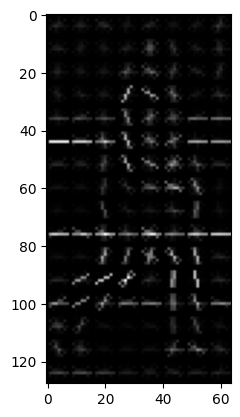

HOG descriptor shape: (3780,)
Primera parte del descriptor: [0.21855353 0.14436023 0.25222066 0.18484703 0.25530457 0.24603745
 0.0366067  0.06692467 0.15302928 0.08399129]


In [38]:
ruta = "assets/person.png"

descriptor_hog = hog_descriptor(ruta_imagen=ruta, k=1,
                                    celdas=8, bins=9, celdas_por_bloque=2)



print("HOG descriptor shape:", descriptor_hog.shape)
print("Primera parte del descriptor:", descriptor_hog[:10])

